# Lesson 7 // Topic modelling

---
Topic modelling is a type of bag-of-words model that aims to summarize a document by describing it in terms of a small number of "topics". The resulting descriptions can then be used for several purposes, for example, to judge similarity between documents and to cluster together similar documents, or for document classification. This notebook covers topic modelling and in particular one method used to do topic modelling, *latent dirichlet allocation*.

As we've seen, in the bag-of-words model a document is represented by:

1. the words that appear in it, and 
2. the frequency with which each word appears

When a number of documents are collected into a corpus, we start by identifying *all* the words that are used by the documents in the corpus -- the "vocabulary" of the corpus. Each document can then be thought of as a (often very) long vector of frequencies (as long as the vocabulary), many of which will be zero. These vectors, stacked upon each other, one per document, give us the document-term matrix.

The "wideness" of the document-term matrix poses a challenge to efficient further analysis, such as clustering and classification. So, we might ask whether we can reduce the dimensionality of the problem by summarizing each document in some way that preserves most of the information contained in the vector of word frequencies, but that makes subsequent analysis easier and more efficient. 

This is what topic modelling does. In a nutshell, it summarizes documents by describing them in terms of a smaller number of topics. Over and above improving the efficency with which further analyses can be done, the resulting summaries contain useful information about what a document is "about".

In this notebook we will:

1. Look at how a topic model attempts to "summarize" the document-term matrix, using a spreadsheet example. Along the way we'll introduce a number of methods for doing topic modelling, and also some fundamental modelling "building blocks" like maximum likelihood.
2. Describe Latent Dirichlet allocation (LDA), a popular method for doing topic modeling that avoids some of the pitfalls of other methods.
3. Show how you can do topic modelling with LDA using the **topicmodelling** package, with further analysis done in **tidytext**. We'll create a topic model for a collection of movie reviews.

The code in this lesson borrows heavily from [Chapter 6](http://tidytextmining.com/topicmodeling.html) of TMR, and also contains some of the material on converting between tidy and non-tidy text formats in [Chapter 5](http://tidytextmining.com/dtm.html).

---

## Summary of topic models

This section gives a short overview of each of the models covered in the Excel sheet. The goal is just to give an intuitive understanding of what each model does. The unigram and mixture of unigram models are not often used, but are useful in building up understanding. I've given some additional mathematical details for those methods, to show how in principle one could build up likelihood functions for the more complex models.

### The unigram model

#### Basic idea

There is a single probability distribution over words that applies to all documents in the corpus. All documents are generated by the *same* probability distribution. The goal is to estimate the parameters of this distribution.

#### Some more details

We are interested in estimating $p(w_{ij})$, the probability that word $i$ "appears in" or "is generated by" document $j$, for all $i=1,\dots,n$ words in the vocabulary and all $j=1,\dots,N$ documents in the corpus. The unigram model assumes that all documents are generated by the same probability distribution, so $p(w_{i1})=p(w_{i2})=\dots=p(w_{iN})$ and we can just drop the $j$ subscript and refer to $p(w_i)$.

The multinomial distribution is the appropriate distribution to use in this context, where we are sampling from a discrete distribution with $n$ classes. The parameter vector of the multinomial distribution is the vector of probabilities $[p(w_1),\dots,p(w_n)]$. 

Say we have three words in our vocabulary $w_1$, $w_2$, $w_3$. The probability that, in a document of 6 words, word 1 appears four times, word 2 twice, and word 3 not all is, is $$p(w_1)^4p(w_2)^2p(w_3)^0$$

This is a joint probability, and is also the *likelihood*. By the principle of maximum likelihood, we try and find the values of $p(w_1)$, $p(w_2)$, $p(w_3)$ that maximize this likelihood. 

Equivalently, we can find the values of $p(w_1)$, $p(w_2)$, $p(w_3)$ that maximize the *log* of the likelihood, given by $4\log(p(w_1)) + 2\log(p(w_2))$. This is usually easier to do.

Over all $N$ documents, the likelihood we want to maximize is given by 

$$\prod_{j=1}^N \prod_{i=1}^n p(w_i) = \prod_{i=1}^n p(w_i)^{\sum_{j=1}^N f_j(w_i)}$$ 

where $f_j(w_i)$ is the observed number of times that word $i$ appears in document $j$.

### Mixture of unigrams

#### Basic idea

Here we say that, rather than there just being a single distribution over words, there are several possible distributions. Each possible distribution can be thought of as a "topic". Put this way, a "topic" is a probability distribution over words - in fact this makes quite a lot of sense (with some topics, some words are more likely to come up).

In the mixture of unigrams model a document can only belong to one topic. Later on we'll see this assumption relaxed, so a document can be a mixture of topics. A good way to think of the mixture of unigrams model is:

1. When we generate a document, we first choose a topic from a set of $K$ topics (we have to set $K$ beforehand). The probability of choosing topic $k$ is $p(z_k)$.
2. We then generate the words in that document from the appropriate distribution. Previously we had a single word distribution with terms like $p(w_i)$. Now we have one distribution for each topic, and the terms are $p(w_i|z=k)$. We read this as "the probability that topic $k$ generates word $i$.  

#### Some more details

We now basically have to estimate the parameters of *several* multinomial distributions, rather than just one, and we *also* have to estimate the probabilities of generating the topics $p(z=1),\dots,p(z=K)$. With $K$ topics, we have $K+Kn$ parameters to estimate.  

Say we have three words in our vocabulary $w_1$, $w_2$, $w_3$. The probability that, in a document of 6 words, word 1 appears four times, word 2 twice, and word 3 not all is, now depends on what "topic" the document belongs to:

* if the document is from topic 1, the probability is $p(w_1|z_1)^4p(w_2|z_1)^2p(w_3|z_1)^0$. The probability that the document is from topic 1 is given by $p(z_1)$. This is *another parameter* that we will have to estimate!
* if the document is from topic 2, the probability is $p(w_1|z_2)^4p(w_2|z_2)^2p(w_3|z_2)^0$. The probability that the document is from topic 1 is given by $p(z_2)$. 
* if the document is from topic 3, the probability is $p(w_1|z_3)^4p(w_2|z_3)^2p(w_3|z_3)^0$. The probability that the document is from topic 1 is given by $p(z_3)$. 

The joint probability is given by:
* multiplying together the probability that a document is from a topic (e.g. $p(z_1)$) with the probability of generating the observed frequencies *given that topic* (e.g. $p(w_1|z_1)^4p(w_2|z_1)^2p(w_3|z_1)^0$). This will give three *joint probabilities*, each one gives the probability of being a particular topic *and* getting the observed word frequencies.
* adding up the three joint probabilities gives the marginal probability of getting the observed frequencies 

$$p(\mathbf{w}) = \sum_{k=1}^K p(z_k)\prod_{i=1}^n p(w_i|z_k)$$

We can again estimate parameter values by maximizing the likelihood. All that needs to be done is to take a product of the joint probabilities worked out above over documents - that is the likelihood function. 

### Latent semantic analysis (LSA)

#### Basic idea

This is a different, non-probabilistic approach that uses matrix factorization. The document-term matrix is factorized, similar to what we saw in the recommendation systems sections. The resulting matrices summarize documents and words respectively, but lose their probabilistic interpretation. 

#### Some more details

See the recommender system notebook on matrix factorization. We can use singular value decomposition to do the matrix factorization.

### Probabilistic latent semantic analysis (pLSA)

#### Basic idea

The core ideas in pLSA are:

1. **Each document is a mixture of topics**. For example, a document could consist of 90% topic 1 and 10% topic 2, while another document could have different proportions of the two topics.
2. **Each topic is a mixture of words**. This mixture, expressed as a probability distribution defined over the words in a vocabulary, can be thought of as the propensity of the topic to use certain words over others. 

The second of these is as for the mixture of unigrams model, but the first is new, and important - because most documents are not about just one topic.

A handy way of thinking of pLSA is to think of how it can be used to generate a document, assuming you know the distribution of topics for the document, and probabilities of generating different words conditional on each topic (of course, in reality finding these distributions is the problem that pLSA is trying to solve!).

To generate a document we would:
1. Start with a number of words you want to generate (say 100)
2. Divide up those "placeholders" for words between topics, in the specified proportions. Say, for example, we want a document with 80% topic 1 and 20% topic 2. 80 of the 100 words will come from topic 1, 20 from topic 2.
3. Draw 80 words from the conditional probability distribution giving the probability of word *i* appearing given topic 1. 
4. Draw 20 words from the conditional probability distribution giving the probability of word *i* appearing given topic 2. 

#### Some more details

Things get a bit hairy here, so I'll just give a sketch. 

In the mixture of unigrams model we model the probability of document $j$ generating word $i$ as 

$$p(w_{ij}) = \sum_{k=1}^K p(w_i|z_k)p(z_k)$$

The topic probabilities are the same for all documents. Put another way, documents are not allowed to be different mixtures of topics.

The pLSA model relaxes this assumption

$$p(w_{ij}) = \sum_{k=1}^K p(w_i,d_j|z_k)p(z_k|d_j)p(d_j)$$

In order to formulate a likelihood function that can be maximized, pLSA needs to respect some probability rules. Specifically, to work out the joint probability that a document $j$ produces a word $i$ the following "ingredients" are needed.

* The probability of word i given topic k, for all i and k. This is the same as before, and gives $nK$ parameters to estimate.
* The "mixture" of topics in each document -- the probability that document $j$ generates topic $k$. This is new, and gives $NK$ parameters to estimate.
* The probability that the corpus generates document $j$. This is also new, and gives $N$ parameters to estimate.

The last of these in particular is tricky conceptually, but it is needed to make sure the probabilities actually come out as probabilities -- that, for example, they sum to one. 

### Latent Dirichlet allocation

#### Basic idea

Latent Dirichlet allocation uses the same basic setup as pLSA:

* *Each document is a mixture of topics*. 
* *Each topic is a mixture of words*. 

In pLSA there topic distribution (the proportion of topics making up a document) is different for each document. That's why there were $nK$ parameters to estimate. LDA says that the topic distributions are drawn from *another* distribution (!), specifically a Dirichlet distribution with parameters $[a_1,\dots,a_K]$. The Dirichlet distribution is a useful distribution for modelling things like proportions and probabilities that sum to one. This means that we only estimate the $K$ parameters of the Dirichlet, substantially less than the $nK$ parameters estimated by pLSA. This also does away with the need to specifically estimate the probability that the corpus generates document $j$. These are the two main benefits of LDA over pLSA.

To generate a document we would:
1. Start with a number of words you want to generate (say 100)
2. Draw a vector of proportions by sampling from a Dirichlet distribution with $[a_1,\dots,a_K]$. This might give, for example, 80\% in topic 1 and 20\% for topic 2.
3. Divide up those "placeholders" for words between topics, in the specified proportions. Say, for example, we want a document with 80% topic 1 and 20% topic 2. 80 of the 100 words will come from topic 1, 20 from topic 2.
4. Draw 80 words from the conditional probability distribution giving the probability of word *i* appearing given topic 1. 
5. Draw 20 words from the conditional probability distribution giving the probability of word *i* appearing given topic 2. 

#### Some more details

LDA is a hierarchical model and estimation is technically complex. The two main approaches are a variational expectation maximisation algorithm, and collapsed Gibbs sampling. Both of these are beyond the scope of this course, but there is a nice explanation of collapsed Gibbs sampling in Chapter 20 of Joel Grus' ["Data Science from Scratch: First Principles with Python"](http://shop.oreilly.com/product/0636920033400.do).

## Testing the topic model on reviews for two movies

In this example we construct a topic model on reviews for two different movies, *Taxi Driver* and *Waterworld*. Since we know that the main "topics" should be to do with the two movies, we can easily assess whether LDA is doing a good job at separating out topics, and when it fails. 

I have used the web scraping notebook from Lesson 3 to scrape 160 reviews of *Taxi Driver*, and 160 reviews of *Waterworld*. You can view IMDb and read the synopsis for [Taxi Driver](http://www.imdb.com/title/tt0075314/) and [Waterworld](http://www.imdb.com/title/tt0114898/). Clearly they are quite different types of movies, although they have some things in common, like being about a loner who protects a young girl from harm.

We start by loading required packages as well as the data.

In [1]:
library(tidyverse)
library(tidytext)
library(topicmodels)

load("data/my_imdb_reviews.RData")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


We then do a bit of data cleaning to make subsequent analyses easier. We change the class of the `review` variable from factor to character, add a document ID variable, and fix a typo in the variable name.

In [2]:
reviews <- as.tibble(reviews)
reviews$review <- as.character(reviews$review) 
reviews$reviewId <- 1:nrow(reviews) 
reviews <- reviews %>% rename(imdbId = imbdId)

We then tokenize the reviews into individual words and remove stop words from the data frame.

In [3]:
tidy_reviews <- reviews %>% 
  unnest_tokens(word, review, token = "words", to_lower = T) %>%
  filter(!word %in% stop_words$word)

tidy_reviews

imdbId,reviewId,word
0075314,1,towering
0075314,1,classic
0075314,1,american
0075314,1,cinematic
0075314,1,power
0075314,1,martin
0075314,1,scorsese
0075314,1,teams
0075314,1,intense
0075314,1,actors


We can now count the number of times each word in our vocabulary was used in each review, creating a "long" (and tidy) format of the document-term matrix. 

In [4]:
reviews_tdf <- tidy_reviews %>%
  group_by(reviewId,word) %>%
  count() %>%  
  ungroup() 

Previously we have created our own "wide" versions of the document-term matrix using the `spread()` function. We did this, for example, when building a bag-of-words model in the Lesson 6 notebook. This was fine when building features for a classification tree (using **rpart**), but some R packages require a particular implementation of document-term matrix. One common implementation is the `DocumentTermMatrix` class provided by the **tm** package. 

The **topicmodelling** package, which we use to implement the LDA topic model, requires the document-term matrix to be provided as a `DocumentTermMatrix` object. Fortunately, **tidytext** provides a number of functions for turning "ordinary" document-term matrices into `DocumentTermMatrix` (or other kinds of) objects, and also for going the other way (tidying document-term matrices). This is described in more detail [here](http://tidytextmining.com/dtm.html#cast-dtm). Essentially, we create the `DocumentTermMatrix` object using `cast_dtm()` as shown below.

In [5]:
dtm_reviews <- reviews_tdf %>% 
  cast_dtm(reviewId, word, n)

We can now estimate the parameters of the topic model using LDA. We use the `LDA()` function provided by the package **topicmodelling**. We need to specify the number of latent variables (topics) we wish to use. 

Notice that the object that is returned by `LDA()` below has a specific class, the "LDA_VEM" class. This is a so-called "S4" object. R provides a number of different systems for object oriented programming: the main ones are an older, more flexible "S3" object class, and a newer, stricter "S4" class. We don't need to worry about these intricacies, but one important practical difference is that the `$` operator (the way you reference variables within an object e.g. `tweets$text`) is not defined for the S4 class. Instead, you use the `@` operator.

In [6]:
set.seed(1234)
reviews_lda <- LDA(dtm_reviews, k = 2)
reviews_lda
str(reviews_lda)

A LDA_VEM topic model with 2 topics.

Formal class 'LDA_VEM' [package "topicmodels"] with 14 slots
  ..@ alpha          : num 0.0315
  ..@ call           : language LDA(x = dtm_reviews, k = 2)
  ..@ Dim            : int [1:2] 320 7992
  ..@ control        :Formal class 'LDA_VEMcontrol' [package "topicmodels"] with 13 slots
  .. .. ..@ estimate.alpha: logi TRUE
  .. .. ..@ alpha         : num 25
  .. .. ..@ seed          : int 1506340150
  .. .. ..@ verbose       : int 0
  .. .. ..@ prefix        : chr "C:\\Users\\STIAAN~1\\AppData\\Local\\Temp\\RtmpeaJWLb\\file3a40fc81966"
  .. .. ..@ save          : int 0
  .. .. ..@ nstart        : int 1
  .. .. ..@ best          : logi TRUE
  .. .. ..@ keep          : int 0
  .. .. ..@ estimate.beta : logi TRUE
  .. .. ..@ var           :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max: int 500
  .. .. .. .. ..@ tol     : num 1e-06
  .. .. ..@ em            :Formal class 'OPTcontrol' [package "topicmodels"] with 2 slots
  .. .. .. .. ..@ iter.max

The main things we are interested in are:

* `beta`: these parameters control the probability of a given topic k generating a particular word i.
* `gamma`: this gives the topic "mixtures" for each document.

We'll first look at the beta parameters and examine which words are most associated with each topic. This will be a good way of checking, in our case, whether the words align themselves into two topics we are expecting (i.e. one to do with *Taxi Driver*, the other *Waterworld*). More generally, you would do this to assess what the topics are about. 

### Word-topic probabilities

We start by creating a data frame containing the "terms" (the words we tokenized the reviews into), and the beta parameters (one beta parameter per-word-per-topic).

In [7]:
term <- as.character(reviews_lda@terms)
topic1 <- reviews_lda@beta[1,]
topic2 <- reviews_lda@beta[2,]
reviews_topics <- tibble(term = term, topic1 = topic1, topic2 = topic2)

The data frame above is not yet in "tidy" format, because the beta parameters are spread across two columns. We use the `gather()` function to get the data into a tidy format. At the same time, we transform the beta parameters into probabilities by exponentiating each beta

In [8]:
reviews_topics <- reviews_topics %>% 
  gather(topic1, topic2, key = "topic", value = "beta") %>%
  mutate(beta = exp(beta)) # pr(topic k generates word i) = exp(beta_ik)
head(reviews_topics)

term,topic,beta
actors,topic1,7.368655e-04
affection,topic1,6.155094e-05
albert,topic1,6.174125e-05
alienated,topic1,5.442699e-89
alienation,topic1,1.598333e-70
american,topic1,1.966619e-04


The **tidytext** package provides a function `tidy()` that tidies a number of different object types, including "LDA_VEM" objects. So you can skip the previous step and use a direct call to `tidy()` the `reviews_lda` object we created earlier. You can use the same approach with `matrix = "gamma"` to extract those parameters.

In [9]:
reviews_topics <- tidy(reviews_lda, matrix = "beta")
head(reviews_topics)

topic,term,beta
1,actors,7.368655e-04
2,actors,8.752578e-04
1,affection,6.155094e-05
2,affection,4.599754e-05
1,albert,6.174125e-05
2,albert,8.738110e-04


Finally, we can extract the top 20 terms used in each topic and arrange these in a tidy format, and plot with a call to `ggplot()`.

In [10]:
top_terms <- reviews_topics %>%
  group_by(topic) %>%
  top_n(20, beta) %>%
  ungroup() %>%
  arrange(topic, -beta)

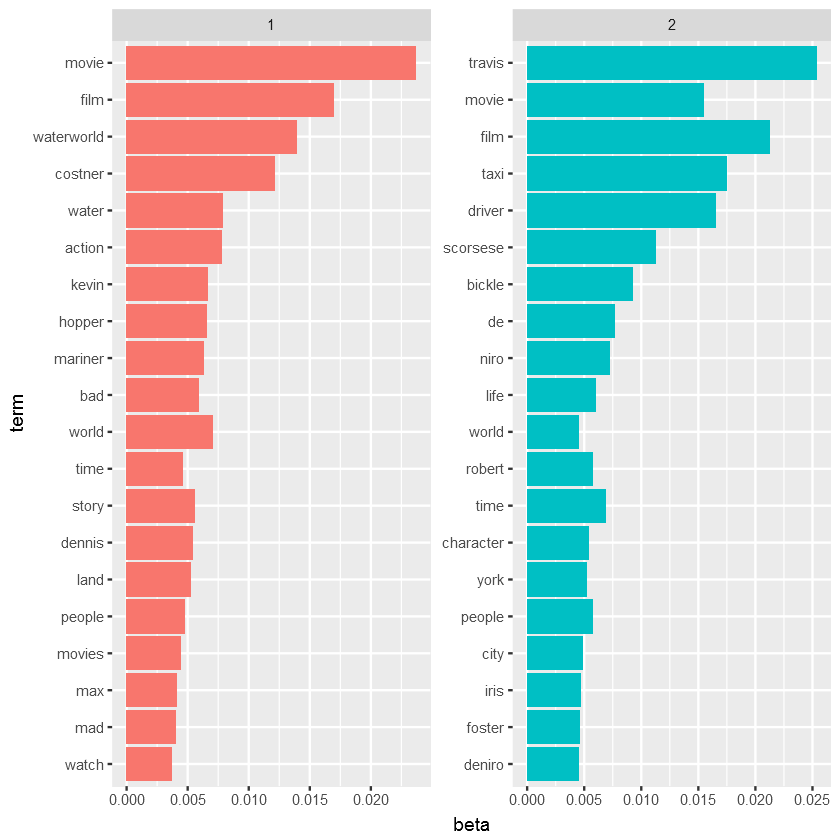

In [11]:
top_terms %>%
  mutate(term = reorder(term, beta)) %>%
  ggplot(aes(term, beta, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free") +
  coord_flip()

This visualization shows use the most frequent words used by each topic, and this gives us a way of understanding what the topics are about. The words used by Topic 1 are mostly to do with *Waterworld* (the movie title, actors' names, some plot elements like "mariner", "land", etc). The words used by Topic 2 are mostly about *Taxi Driver*. So, the topic model is clearly picking up that the reviews are largely about two "topics", and that these topics relate to the movies being reviewed. Also note that some words (like "movie" and "film") are common to both topics. This is a benefit of LDA: words can be associated with more than one topic.

A different way of drawing out the differences between topics is to look at which words have the greatest *difference* in beta values between Topic 1 and Topic 2. This could be done in several ways but a good default is to take the advice in TMR anduse the log (base 2) ratio of the two betas: $log2(\beta_2/\beta_1)$. Any log ratio is symmetrical: the log ratio for $\beta_2/\beta_1$ is -1 times the log ratio for $\beta_1/\beta_2$. A base of 2 in the log ratio makes things a bit easier to interpret. The log (base 2) ratio increases by 1 for every doubling of $\beta_2$ (relative to $\beta_1$) leads to an increase in the log ratio of 1. 

We calculate the log ratios below and plot the words with the biggest positive and negative log ratios. We first filter out common words, such as those that have a beta greater than 1/1000 in at least one topic.

In [12]:
beta_spread <- reviews_topics %>%
  mutate(topic = paste0("topic", topic)) %>%
  spread(topic, beta) %>%
  filter(topic1 > .001 | topic2 > .001) %>%
  mutate(log_ratio = log2(topic2 / topic1))

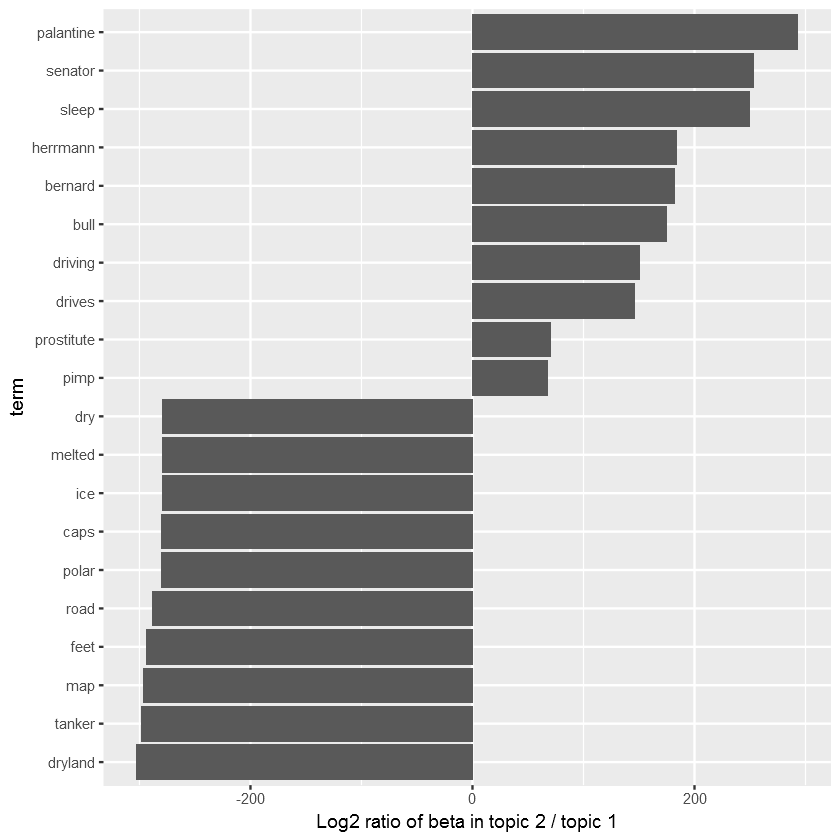

In [13]:
beta_spread %>%
  group_by(direction = log_ratio > 0) %>%
  top_n(10, abs(log_ratio)) %>%
  ungroup() %>%
  mutate(term = reorder(term, log_ratio)) %>%
  ggplot(aes(term, log_ratio)) +
  geom_col() +
  labs(y = "Log2 ratio of beta in topic 2 / topic 1") +
  coord_flip()

### Document-topic probabilities

LDA models each document as a mixture of topics. These mixtures can be used in a straightforward way to assess whether a particular document is "mostly about Topic 1" or "mostly about Topic 2". In our case, since we have a very clear idea both of what the topics are about (i.e. how topics map onto movies) and what the reviews were *supposed to be about* we can examine these mixtures and see whether they make sense.

The "mixture" of topics in each document is given by document-topic probabilities referred to collectively as "gamma". Below we extract these from the object containing the LDA results, and merge the gamma values back into the original data frame containing the reviews. 

In [14]:
reviews_gamma <- reviews %>% 
    left_join(tidy(reviews_lda, matrix = "gamma") %>% 
    mutate(reviewId = as.numeric(document)) %>% # some cleaning to make key variable (reviewId) usable
    select(-document) %>%
    spread(key = topic, value = gamma, sep = "_"))

Joining, by = "reviewId"


We know that Topic 1 is clearly about *Waterworld* and Topic 2 is about *Taxi Driver*. We can therefore ask: 

1. How many of the reviews for *Taxi Driver* did the LDA estimate to be *mostly* about Topic 1 (*Waterworld*)?
2. How many of the reviews for *Waterwold* did the LDA estimate to be *mostly* about Topic 2 (*Taxi Driver*)? 

We answer this question below (*Taxi Driver* has `imdbID = 0075314`). Six of the 160 *Taxi Driver* reviews were estimated to mostly be about Topic 1, while eight of the 160 *Waterworld* reviews were mostly about Topic 2, according to LDA. 

In [15]:
reviews_gamma %>% group_by(imdbId) %>% summarize(ntopic1 = sum(topic_1 > 0.5))

imdbId,ntopic1
0075314,5
0114898,160


Let's have a look at a few cases where the topic model got it wrong. First, we can look at a few reviews for *Taxi Driver* that the model said were mostly about Topic 1.

In [16]:
reviews_gamma %>% filter(imdbId == "0075314") %>% arrange(desc(topic_1)) %>% head(3)

imdbId,review,reviewId,topic_1,topic_2
0075314,what a sorry excuse of a movie and a waste of 2 hours of my life don t get me wrong i like old movies from the musicals to the epics and any well acted movies i bought the dvd thinking that this was a highly rated classic from the 70s what it really is actually is a 2 hours borefest with dull acting and practically nothing happening for the first 65 70 mins of the movie the story revolves around a lonely 26 years old taxi driver that was a loner and outcast and clearly have physcological issues his ill conceived atttempts to woo a young women named betsy backfired and push him finally into mental instability then as if suddenly realizing that there is clearly nothing much in both the script and the story line in this sorry excuse for a movie the director saw fit to inject the last 10 mins with a meaningless violent bloody gunfight the entire movie is so meaningless that people must be blind to rate this as a classic i urge anyone thinking of renting or buying this movie to think twice don t throw away 2 hours of your life watching this piece of crap,31,0.6811584,0.3188416
0075314,i rented it again this week and it reminded me why i saw it 4 times the weekend that it was released exceptional performances by the cast exceptional direction wonderful edgy and creative screenplay great soundtrack it is a true original and it catches de niro scorsese keitel and schrader at the top of their games if i had one movie on a desert island i would wish it to be this one i can t wait for the remastered re release,95,0.5983448,0.4016552
0075314,i had some hopes for this movie since i found it among the 250 best movies list so i decided to give it two hours of my life then wow what was that the story line is not making any sense at all it is like the writer and the director wanted to make a flashy movie by adding big names like de nero and jodi foster to it some unconnected scenes with guns,97,0.5416345,0.4583655


Compare these to the *Taxi Driver* reviews that were "most" about **Topic 2** (which was, remember, to do with *Taxi Driver*)

In [17]:
reviews_gamma %>% filter(imdbId == "0075314") %>% arrange(topic_1) %>% head(3)

imdbId,review,reviewId,topic_1,topic_2


Let's do the same thing for *Waterworld*: look at a few reviews that the model said were mostly about Topic 2 (*Taxi Driver*).

In [18]:
reviews_gamma %>% filter(imdbId != "0075314") %>% arrange(topic_1) %>% head(3)

imdbId,review,reviewId,topic_1,topic_2
0114898,one of the most disturbing trends in movies now is the high ratio of eye candy movies to intelligent movies and i get the feeling waterworld ushered in the era unoffcially since this movie was released we ve had to tolerate independence day godzilla and armageddon not to mention all the other ones i can t think of right now to be fair this movie has an amazing visual flair enough to keep me from hating it the script was excellent in it s premise but pretty putrid in it s execution mostly obvious in the nonexistant characters the only one with personality was the deacon but with dennis hopper playing the role that s to be expected kevin costner just sucked i can understand restrained acting but he was giving keanu reeves a run for worst big name actor i gotta thank director kevin reynolds for doing his best to make this a good film for the most part he succeeded and in the process raked up the second largest bill in existence and it s not too hard to see where the money went oh well at least the sets were more realistic than the computer generated ones that would ve appeared in their place today,253,0.5442355,0.4557645
0114898,somebody thought enough years have passed and nobody will notice a mad max rip off and one might thought that after the mad max movies have passed there is enough data to make at least something watchable it was a bad guess the designs are ugly the results are even uglier this world has metal catamarans to play the rust yet space is not a problem there are enough plastics in the water but there wasn t enough to make lighter plastic boats everything is made to look old and broken yet liquids are hold in glass recipients lots of glass one might think over water people would care about sun burns they are dressed in skin revealing clothes and to make the irony worse most of the actors are quite white the same way one might think that a survivor on high seas who depends on exchanging junk with the floating markets would know how to be polite at least to keep his precious cargo nope the main character has the iq and social skills of a half done hamburger contact me with questions comments or suggestions ryitfork bitmail ch,225,0.7268877,0.2731123
0114898,alot of people hate waterworld they think it is tacky and an unimaginative rip off of mad max not true i love the storyline and the characters the dude with the long red hair is my fave and the amazing soundtrack makes this a quality film in its own right,278,0.7681721,0.2318279


And finally, compare the reviews above to reviews that were "most" about Topic 1.

In [19]:
reviews_gamma %>% filter(imdbId != "0075314") %>% arrange(topic_2) %>% head(3)

imdbId,review,reviewId,topic_1,topic_2


## Exercises

1. Do topic modelling on the set of Trump tweets that we have been using all along. 
    + experiment with the number of topics.
    + look at topics for tweets created in (a) the year before and (b) the year after he became president. Are there differences?
2. Work through [this example](http://tidytextmining.com/topicmodeling.html#library-heist) in Chapter 6 of TMR. There is also a topic modelling part to the case study in [Chapter 9](http://tidytextmining.com/usenet.html).
